# Running TARDIS with a custom packet source

In [1]:
import numpy as np
from tardis import constants as const
from astropy import units as u
from tardis.montecarlo.packet_source import BasePacketSource
from tardis import run_tardis
import matplotlib.pyplot as plt
from tardis.io.atom_data import download_atom_data

/usr/share/miniconda/envs/tardis/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)


/usr/share/miniconda/envs/tardis/lib/python3.6/site-packages/tardis_sn-3.0.dev3382-py3.6-linux-x86_64.egg/tardis/io/util.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
download_atom_data('kurucz_cd23_chianti_H_He')

[tardis.io.config_internal][WARNING]  Configuration File /home/vsts/.astropy/config/tardis_internal_config.yml does not exist - creating new one from default (config_internal.py:16)


CRITICAL:root:
********************************************************************************

TARDIS will download different kinds of data (e.g. atomic) to its data directory /home/vsts/Downloads/tardis-data

TARDIS DATA DIRECTORY not specified in /home/vsts/.astropy/config/tardis_internal_config.yml:

ASSUMING DEFAULT DATA DIRECTORY /home/vsts/Downloads/tardis-data
 YOU CAN CHANGE THIS AT ANY TIME IN /home/vsts/.astropy/config/tardis_internal_config.yml 

******************************************************************************** 




[tardis.io.atom_data.atom_web_download][INFO   ]  Downloading atomic data from https://media.githubusercontent.com/media/tardis-sn/tardis-refdata/master/atom_data/kurucz_cd23_chianti_H_He.h5 to /home/vsts/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (atom_web_download.py:47)


INFO:tardis.io.atom_data.atom_web_download:Downloading atomic data from https://media.githubusercontent.com/media/tardis-sn/tardis-refdata/master/atom_data/kurucz_cd23_chianti_H_He.h5 to /home/vsts/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5


Custom packet source class that is derived from BasePacketSource. The method create_packets (which returns ```nus, mus, energies```) has to be defined.

In [3]:
class TruncBlackbodySource(BasePacketSource):
    """
        Custom inner boundary source class to replace the Blackbody source
        with a truncated Blackbody source.
    """
    
    def __init__(self, seed, truncation_wavelength):
        super().__init__(seed)
        self.truncation_wavelength = truncation_wavelength
    
    def create_packets(self, T, no_of_packets,
                       drawing_sample_size=None):
        """
        Packet source that generates a truncated Blackbody source.
        
        Parameters
        ----------
        T : float
            Blackbody temperature
        no_of_packets : int
            number of packets to be created
        truncation_wavelength : float
            truncation wavelength in Angstrom. 
            Only wavelengths higher than the truncation wavelength
            will be sampled.
        """
        
        
        # Use mus and energies from normal blackbody source.
        mus = self.create_zero_limb_darkening_packet_mus(no_of_packets)
        energies = self.create_uniform_packet_energies(no_of_packets)

        # If not specified, draw 2 times as many packets and reject any beyond no_of_packets.
        if drawing_sample_size is None:
            drawing_sample_size = 2 * no_of_packets

        # Blackbody will be truncated below truncation_wavelength / above truncation_frequency.
        truncation_frequency = u.Quantity(self.truncation_wavelength, u.Angstrom).to(
                                          u.Hz, equivalencies=u.spectral()).value
        
        # Draw nus from blackbody distribution and reject based on truncation_frequency.
        # If more nus.shape[0] > no_of_packets use only the first no_of_packets.
        nus = self.create_blackbody_packet_nus(T, drawing_sample_size)
        nus = nus[nus<truncation_frequency][:no_of_packets]
        
        
        # Only required if the truncation wavelength is too big compared to the maximum 
        # of the blackbody distribution. Keep sampling until nus.shape[0] > no_of_packets.
        while nus.shape[0] < no_of_packets:
            additional_nus = self.create_blackbody_packet_nus(
                T, drawing_sample_size
            )
            mask = additional_nus < truncation_frequency
            additional_nus = additional_nus[mask][:no_of_packets]
            nus = np.hstack([nus, additional_nus])[:no_of_packets]
            
        return nus, mus, energies

In [4]:
packet_source = TruncBlackbodySource(
    53253, truncation_wavelength=2000
)

In [5]:
mdl = run_tardis('tardis_example.yml',
                 packet_source=packet_source)
mdl_norm = run_tardis('tardis_example.yml')

[tardis.plasma.standard_plasmas][INFO   ]  Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:74)


INFO:tardis.plasma.standard_plasmas:Reading Atomic Data from kurucz_cd23_chianti_H_He.h5


[tardis.io.atom_data.util][INFO   ]  Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path. Exists in TARDIS Data repo /home/vsts/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (util.py:29)


INFO:tardis.io.atom_data.util:Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path. Exists in TARDIS Data repo /home/vsts/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
 (warnings.py:99)


  exec(code_obj, self.user_global_ns, self.user_ns)



[tardis.io.atom_data.base][INFO   ]  Read Atom Data with UUID=6f7b09e887a311e7a06b246e96350010 and MD5=864f1753714343c41f99cb065710cace. (base.py:184)


INFO:tardis.io.atom_data.base:Read Atom Data with UUID=6f7b09e887a311e7a06b246e96350010 and MD5=864f1753714343c41f99cb065710cace.


[tardis.io.atom_data.base][INFO   ]  Non provided atomic data: synpp_refs, photoionization_data (base.py:187)


INFO:tardis.io.atom_data.base:Non provided atomic data: synpp_refs, photoionization_data


[tardis.simulation.base][INFO   ]  Starting iteration 1/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 1/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.01654e+42 erg / s Luminosity absorbed = 2.59302e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.01654e+42 erg / s Luminosity absorbed = 2.59302e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9926.501965  9415.064544  0.400392  0.676142
	5      9852.611678  9680.145245  0.211205  0.246877
	10     9779.813302  9545.076336  0.142695  0.149216
	15     9708.082813  9332.585303  0.104556  0.109091

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9926.501965  9415.064544  0.400392  0.676142
	5      9852.611678  9680.145245  0.211205  0.246877
	10     9779.813302  9545.076336  0.142695  0.149216
	15     9708.082813  9332.585303  0.104556  0.109091




[tardis.simulation.base][INFO   ]  t_inner 9933.952 K -- next t_inner 11419.135 K (base.py:352)


INFO:tardis.simulation.base:t_inner 9933.952 K -- next t_inner 11419.135 K


[tardis.simulation.base][INFO   ]  Starting iteration 2/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 2/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.39454e+43 erg / s Luminosity absorbed = 4.56926e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.39454e+43 erg / s Luminosity absorbed = 4.56926e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9415.064544   9970.812960  0.676142  0.940442
	5      9680.145245  10279.136485  0.246877  0.341337
	10     9545.076336  10219.670653  0.149216  0.200740
	15     9332.585303   9973.073546  0.109091  0.146664

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9415.064544   9970.812960  0.676142  0.940442
	5      9680.145245  10279.136485  0.246877  0.341337
	10     9545.076336  10219.670653  0.149216  0.200740
	15     9332.585303   9973.073546  0.109091  0.146664




[tardis.simulation.base][INFO   ]  t_inner 11419.135 K -- next t_inner 9952.280 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11419.135 K -- next t_inner 9952.280 K


[tardis.simulation.base][INFO   ]  Starting iteration 3/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 3/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.16237e+42 erg / s Luminosity absorbed = 2.53255e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.16237e+42 erg / s Luminosity absorbed = 2.53255e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9970.812960  9417.889347  0.940442  0.675257
	5      10279.136485  9709.399575  0.341337  0.243531
	10     10219.670653  9613.131035  0.200740  0.146685
	15      9973.073546  9345.735761  0.146664  0.110670

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9970.812960  9417.889347  0.940442  0.675257
	5      10279.136485  9709.399575  0.341337  0.243531
	10     10219.670653  9613.131035  0.200740  0.146685
	15      9973.073546  9345.735761  0.146664  0.110670




[tardis.simulation.base][INFO   ]  t_inner 9952.280 K -- next t_inner 11337.549 K (base.py:352)


INFO:tardis.simulation.base:t_inner 9952.280 K -- next t_inner 11337.549 K


[tardis.simulation.base][INFO   ]  Starting iteration 4/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 4/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.35049e+43 erg / s Luminosity absorbed = 4.48494e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.35049e+43 erg / s Luminosity absorbed = 4.48494e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9417.889347   9922.176827  0.675257  0.931303
	5      9709.399575  10215.117227  0.243531  0.337169
	10     9613.131035  10138.347429  0.146685  0.199124
	15     9345.735761   9901.525879  0.110670  0.145942

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9417.889347   9922.176827  0.675257  0.931303
	5      9709.399575  10215.117227  0.243531  0.337169
	10     9613.131035  10138.347429  0.146685  0.199124
	15     9345.735761   9901.525879  0.110670  0.145942




[tardis.simulation.base][INFO   ]  t_inner 11337.549 K -- next t_inner 10041.030 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11337.549 K -- next t_inner 10041.030 K


[tardis.simulation.base][INFO   ]  Starting iteration 5/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 5/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.42074e+42 erg / s Luminosity absorbed = 2.65685e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.42074e+42 erg / s Luminosity absorbed = 2.65685e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9922.176827  9359.082979  0.931303  0.723854
	5      10215.117227  9704.019148  0.337169  0.252366
	10     10138.347429  9640.144472  0.199124  0.152209
	15      9901.525879  9393.413611  0.145942  0.112247

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9922.176827  9359.082979  0.931303  0.723854
	5      10215.117227  9704.019148  0.337169  0.252366
	10     10138.347429  9640.144472  0.199124  0.152209
	15      9901.525879  9393.413611  0.145942  0.112247




[tardis.simulation.base][INFO   ]  t_inner 10041.030 K -- next t_inner 11261.801 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10041.030 K -- next t_inner 11261.801 K


[tardis.simulation.base][INFO   ]  Starting iteration 6/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 6/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.32318e+43 erg / s Luminosity absorbed = 4.28524e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.32318e+43 erg / s Luminosity absorbed = 4.28524e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9359.082979   9896.296746  0.723854  0.914484
	5      9704.019148  10163.629122  0.252366  0.337554
	10     9640.144472  10025.549681  0.152209  0.204060
	15     9393.413611   9883.249505  0.112247  0.144352

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9359.082979   9896.296746  0.723854  0.914484
	5      9704.019148  10163.629122  0.252366  0.337554
	10     9640.144472  10025.549681  0.152209  0.204060
	15     9393.413611   9883.249505  0.112247  0.144352




[tardis.simulation.base][INFO   ]  t_inner 11261.801 K -- next t_inner 10076.331 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11261.801 K -- next t_inner 10076.331 K


[tardis.simulation.base][INFO   ]  Starting iteration 7/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 7/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.52844e+42 erg / s Luminosity absorbed = 2.70310e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.52844e+42 erg / s Luminosity absorbed = 2.70310e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9896.296746  9376.389179  0.914484  0.729442
	5      10163.629122  9681.313214  0.337554  0.262445
	10     10025.549681  9606.852512  0.204060  0.155523
	15      9883.249505  9330.649031  0.144352  0.116486

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9896.296746  9376.389179  0.914484  0.729442
	5      10163.629122  9681.313214  0.337554  0.262445
	10     10025.549681  9606.852512  0.204060  0.155523
	15      9883.249505  9330.649031  0.144352  0.116486




[tardis.simulation.base][INFO   ]  t_inner 10076.331 K -- next t_inner 11229.806 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10076.331 K -- next t_inner 11229.806 K


[tardis.simulation.base][INFO   ]  Starting iteration 8/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 8/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.29885e+43 erg / s Luminosity absorbed = 4.32563e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.29885e+43 erg / s Luminosity absorbed = 4.32563e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9376.389179   9862.040389  0.729442  0.925375
	5      9681.313214  10147.368588  0.262445  0.333664
	10     9606.852512  10076.910700  0.155523  0.197614
	15     9330.649031   9825.343233  0.116486  0.144842

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9376.389179   9862.040389  0.729442  0.925375
	5      9681.313214  10147.368588  0.262445  0.333664
	10     9606.852512  10076.910700  0.155523  0.197614
	15     9330.649031   9825.343233  0.116486  0.144842




[tardis.simulation.base][INFO   ]  t_inner 11229.806 K -- next t_inner 10141.394 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11229.806 K -- next t_inner 10141.394 K


[tardis.simulation.base][INFO   ]  Starting iteration 9/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 9/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.76008e+42 erg / s Luminosity absorbed = 2.76840e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.76008e+42 erg / s Luminosity absorbed = 2.76840e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9862.040389  9400.831296  0.925375  0.733678
	5      10147.368588  9651.431039  0.333664  0.267756
	10     10076.910700  9563.516709  0.197614  0.161475
	15      9825.343233  9393.136901  0.144842  0.116708

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9862.040389  9400.831296  0.925375  0.733678
	5      10147.368588  9651.431039  0.333664  0.267756
	10     10076.910700  9563.516709  0.197614  0.161475
	15      9825.343233  9393.136901  0.144842  0.116708




[tardis.simulation.base][INFO   ]  t_inner 10141.394 K -- next t_inner 11151.887 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10141.394 K -- next t_inner 11151.887 K


[tardis.simulation.base][INFO   ]  Starting iteration 10/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 10/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.27114e+43 erg / s Luminosity absorbed = 4.12858e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.27114e+43 erg / s Luminosity absorbed = 4.12858e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9400.831296   9886.109086  0.733678  0.883930
	5      9651.431039  10163.780122  0.267756  0.324578
	10     9563.516709  10103.547384  0.161475  0.190547
	15     9393.136901   9923.824236  0.116708  0.136391

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9400.831296   9886.109086  0.733678  0.883930
	5      9651.431039  10163.780122  0.267756  0.324578
	10     9563.516709  10103.547384  0.161475  0.190547
	15     9393.136901   9923.824236  0.116708  0.136391




[tardis.simulation.base][INFO   ]  t_inner 11151.887 K -- next t_inner 10180.214 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11151.887 K -- next t_inner 10180.214 K


[tardis.simulation.base][INFO   ]  Starting iteration 11/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 11/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.89633e+42 erg / s Luminosity absorbed = 2.80790e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.89633e+42 erg / s Luminosity absorbed = 2.80790e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9886.109086  9447.744250  0.883930  0.731489
	5      10163.780122  9778.639583  0.324578  0.260343
	10     10103.547384  9625.614085  0.190547  0.160368
	15      9923.824236  9472.038340  0.136391  0.114829

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9886.109086  9447.744250  0.883930  0.731489
	5      10163.780122  9778.639583  0.324578  0.260343
	10     10103.547384  9625.614085  0.190547  0.160368
	15      9923.824236  9472.038340  0.136391  0.114829




[tardis.simulation.base][INFO   ]  t_inner 10180.214 K -- next t_inner 11108.516 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10180.214 K -- next t_inner 11108.516 K


[tardis.simulation.base][INFO   ]  Starting iteration 12/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 12/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.24888e+43 erg / s Luminosity absorbed = 4.08951e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.24888e+43 erg / s Luminosity absorbed = 4.08951e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9447.744250   9878.427673  0.731489  0.877515
	5      9778.639583  10155.600887  0.260343  0.318893
	10     9625.614085  10051.580970  0.160368  0.192144
	15     9472.038340   9826.991580  0.114829  0.138521

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9447.744250   9878.427673  0.731489  0.877515
	5      9778.639583  10155.600887  0.260343  0.318893
	10     9625.614085  10051.580970  0.160368  0.192144
	15     9472.038340   9826.991580  0.114829  0.138521




[tardis.simulation.base][INFO   ]  t_inner 11108.516 K -- next t_inner 10230.583 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11108.516 K -- next t_inner 10230.583 K


[tardis.simulation.base][INFO   ]  Starting iteration 13/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 13/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 9.03073e+42 erg / s Luminosity absorbed = 2.90452e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 9.03073e+42 erg / s Luminosity absorbed = 2.90452e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9878.427673  9433.315452  0.877515  0.755534
	5      10155.600887  9720.880708  0.318893  0.270945
	10     10051.580970  9640.261926  0.192144  0.161599
	15      9826.991580  9449.035777  0.138521  0.117640

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9878.427673  9433.315452  0.877515  0.755534
	5      10155.600887  9720.880708  0.318893  0.270945
	10     10051.580970  9640.261926  0.192144  0.161599
	15      9826.991580  9449.035777  0.138521  0.117640




[tardis.simulation.base][INFO   ]  t_inner 10230.583 K -- next t_inner 11080.099 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10230.583 K -- next t_inner 11080.099 K


[tardis.simulation.base][INFO   ]  Starting iteration 14/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 14/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.23189e+43 erg / s Luminosity absorbed = 4.08841e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.23189e+43 erg / s Luminosity absorbed = 4.08841e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9433.315452   9819.442378  0.755534  0.897622
	5      9720.880708  10138.383589  0.270945  0.317168
	10     9640.261926  10089.042415  0.161599  0.186716
	15     9449.035777   9892.294467  0.117640  0.134247

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9433.315452   9819.442378  0.755534  0.897622
	5      9720.880708  10138.383589  0.270945  0.317168
	10     9640.261926  10089.042415  0.161599  0.186716
	15     9449.035777   9892.294467  0.117640  0.134247




[tardis.simulation.base][INFO   ]  t_inner 11080.099 K -- next t_inner 10274.554 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11080.099 K -- next t_inner 10274.554 K


[tardis.simulation.base][INFO   ]  Starting iteration 15/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 15/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 9.20594e+42 erg / s Luminosity absorbed = 2.93529e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 9.20594e+42 erg / s Luminosity absorbed = 2.93529e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9819.442378  9509.931824  0.897622  0.739878
	5      10138.383589  9702.698363  0.317168  0.276278
	10     10089.042415  9682.781589  0.186716  0.162854
	15      9892.294467  9481.368860  0.134247  0.119423

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9819.442378  9509.931824  0.897622  0.739878
	5      10138.383589  9702.698363  0.317168  0.276278
	10     10089.042415  9682.781589  0.186716  0.162854
	15      9892.294467  9481.368860  0.134247  0.119423




[tardis.simulation.base][INFO   ]  t_inner 10274.554 K -- next t_inner 11021.320 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10274.554 K -- next t_inner 11021.320 K


[tardis.simulation.base][INFO   ]  Starting iteration 16/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 16/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.20786e+43 erg / s Luminosity absorbed = 3.98754e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.20786e+43 erg / s Luminosity absorbed = 3.98754e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9509.931824   9786.973709  0.739878  0.884296
	5      9702.698363  10019.560208  0.276278  0.326831
	10     9682.781589   9933.282564  0.162854  0.193954
	15     9481.368860   9722.614495  0.119423  0.140501

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9509.931824   9786.973709  0.739878  0.884296
	5      9702.698363  10019.560208  0.276278  0.326831
	10     9682.781589   9933.282564  0.162854  0.193954
	15     9481.368860   9722.614495  0.119423  0.140501




[tardis.simulation.base][INFO   ]  t_inner 11021.320 K -- next t_inner 10321.203 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11021.320 K -- next t_inner 10321.203 K


[tardis.simulation.base][INFO   ]  Starting iteration 17/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 17/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 9.35180e+42 erg / s Luminosity absorbed = 3.00810e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 9.35180e+42 erg / s Luminosity absorbed = 3.00810e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9786.973709  9529.410632  0.884296  0.754263
	5      10019.560208  9817.837911  0.326831  0.270679
	10      9933.282564  9743.407316  0.193954  0.162481
	15      9722.614495  9504.601719  0.140501  0.119547

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9786.973709  9529.410632  0.884296  0.754263
	5      10019.560208  9817.837911  0.326831  0.270679
	10      9933.282564  9743.407316  0.193954  0.162481
	15      9722.614495  9504.601719  0.140501  0.119547




[tardis.simulation.base][INFO   ]  t_inner 10321.203 K -- next t_inner 10984.681 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10321.203 K -- next t_inner 10984.681 K


[tardis.simulation.base][INFO   ]  Starting iteration 18/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 18/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.19508e+43 erg / s Luminosity absorbed = 3.90940e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.19508e+43 erg / s Luminosity absorbed = 3.90940e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9529.410632   9728.077548  0.754263  0.882123
	5      9817.837911   9996.107673  0.270679  0.321617
	10     9743.407316  10009.664332  0.162481  0.185913
	15     9504.601719   9770.541671  0.119547  0.136599

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9529.410632   9728.077548  0.754263  0.882123
	5      9817.837911   9996.107673  0.270679  0.321617
	10     9743.407316  10009.664332  0.162481  0.185913
	15     9504.601719   9770.541671  0.119547  0.136599




[tardis.simulation.base][INFO   ]  t_inner 10984.681 K -- next t_inner 10341.740 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10984.681 K -- next t_inner 10341.740 K


[tardis.simulation.base][INFO   ]  Starting iteration 19/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 19/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 9.45988e+42 erg / s Luminosity absorbed = 3.00355e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 9.45988e+42 erg / s Luminosity absorbed = 3.00355e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9728.077548  9523.469674  0.882123  0.763011
	5       9996.107673  9795.641081  0.321617  0.274433
	10     10009.664332  9743.486891  0.185913  0.162947
	15      9770.541671  9515.421119  0.136599  0.119628

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9728.077548  9523.469674  0.882123  0.763011
	5       9996.107673  9795.641081  0.321617  0.274433
	10     10009.664332  9743.486891  0.185913  0.162947
	15      9770.541671  9515.421119  0.136599  0.119628




[tardis.simulation.base][INFO   ]  t_inner 10341.740 K -- next t_inner 10943.480 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10341.740 K -- next t_inner 10943.480 K


[tardis.simulation.base][INFO   ]  Starting iteration 20/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 20/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.17641e+43 erg / s Luminosity absorbed = 3.85385e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.17641e+43 erg / s Luminosity absorbed = 3.85385e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Simulation finished in 20 iterations and took 40.02 s (base.py:308)


INFO:tardis.simulation.base:Simulation finished in 20 iterations and took 40.02 s


[tardis.plasma.standard_plasmas][INFO   ]  Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:74)


INFO:tardis.plasma.standard_plasmas:Reading Atomic Data from kurucz_cd23_chianti_H_He.h5


[tardis.io.atom_data.util][INFO   ]  Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path. Exists in TARDIS Data repo /home/vsts/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (util.py:29)


INFO:tardis.io.atom_data.util:Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path. Exists in TARDIS Data repo /home/vsts/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
 (warnings.py:99)


  exec(code_obj, self.user_global_ns, self.user_ns)



[tardis.io.atom_data.base][INFO   ]  Read Atom Data with UUID=6f7b09e887a311e7a06b246e96350010 and MD5=864f1753714343c41f99cb065710cace. (base.py:184)


INFO:tardis.io.atom_data.base:Read Atom Data with UUID=6f7b09e887a311e7a06b246e96350010 and MD5=864f1753714343c41f99cb065710cace.


[tardis.io.atom_data.base][INFO   ]  Non provided atomic data: synpp_refs, photoionization_data (base.py:187)


INFO:tardis.io.atom_data.base:Non provided atomic data: synpp_refs, photoionization_data


[tardis.simulation.base][INFO   ]  Starting iteration 1/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 1/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 7.96915e+42 erg / s Luminosity absorbed = 2.63370e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 7.96915e+42 erg / s Luminosity absorbed = 2.63370e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9926.501965  10171.209103  0.400392  0.500372
	5      9852.611678  10306.111379  0.211205  0.191331
	10     9779.813302  10174.379204  0.142695  0.116864
	15     9708.082813   9910.442275  0.104556  0.085962

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9926.501965  10171.209103  0.400392  0.500372
	5      9852.611678  10306.111379  0.211205  0.191331
	10     9779.813302  10174.379204  0.142695  0.116864
	15     9708.082813   9910.442275  0.104556  0.085962




[tardis.simulation.base][INFO   ]  t_inner 9933.952 K -- next t_inner 11453.040 K (base.py:352)


INFO:tardis.simulation.base:t_inner 9933.952 K -- next t_inner 11453.040 K


[tardis.simulation.base][INFO   ]  Starting iteration 2/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 2/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.40398e+43 erg / s Luminosity absorbed = 4.68639e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.40398e+43 erg / s Luminosity absorbed = 4.68639e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10171.209103  11518.516702  0.500372  0.538298
	5      10306.111379  11554.412119  0.191331  0.217946
	10     10174.379204  11373.574056  0.116864  0.132935
	15      9910.442275  11040.788763  0.085962  0.099700

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10171.209103  11518.516702  0.500372  0.538298
	5      10306.111379  11554.412119  0.191331  0.217946
	10     10174.379204  11373.574056  0.116864  0.132935
	15      9910.442275  11040.788763  0.085962  0.099700




[tardis.simulation.base][INFO   ]  t_inner 11453.040 K -- next t_inner 9948.201 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11453.040 K -- next t_inner 9948.201 K


[tardis.simulation.base][INFO   ]  Starting iteration 3/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 3/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.16814e+42 erg / s Luminosity absorbed = 2.50161e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.16814e+42 erg / s Luminosity absorbed = 2.50161e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11518.516702  10501.129902  0.538298  0.438591
	5      11554.412119  10869.940791  0.217946  0.160809
	10     11373.574056  10558.269547  0.132935  0.103807
	15     11040.788763  10185.648701  0.099700  0.079165

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11518.516702  10501.129902  0.538298  0.438591
	5      11554.412119  10869.940791  0.217946  0.160809
	10     11373.574056  10558.269547  0.132935  0.103807
	15     11040.788763  10185.648701  0.099700  0.079165




[tardis.simulation.base][INFO   ]  t_inner 9948.201 K -- next t_inner 11328.896 K (base.py:352)


INFO:tardis.simulation.base:t_inner 9948.201 K -- next t_inner 11328.896 K


[tardis.simulation.base][INFO   ]  Starting iteration 4/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 4/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.34487e+43 erg / s Luminosity absorbed = 4.47931e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.34487e+43 erg / s Luminosity absorbed = 4.47931e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10501.129902  11527.008679  0.438591  0.512509
	5      10869.940791  11706.138980  0.160809  0.196458
	10     10558.269547  11444.208532  0.103807  0.124092
	15     10185.648701  11085.857161  0.079165  0.093694

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10501.129902  11527.008679  0.438591  0.512509
	5      10869.940791  11706.138980  0.160809  0.196458
	10     10558.269547  11444.208532  0.103807  0.124092
	15     10185.648701  11085.857161  0.079165  0.093694




[tardis.simulation.base][INFO   ]  t_inner 11328.896 K -- next t_inner 10054.300 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11328.896 K -- next t_inner 10054.300 K


[tardis.simulation.base][INFO   ]  Starting iteration 5/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 5/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.44348e+42 erg / s Luminosity absorbed = 2.68000e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.44348e+42 erg / s Luminosity absorbed = 2.68000e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11527.008679  10659.382763  0.512509  0.433573
	5      11706.138980  11038.244897  0.196458  0.158494
	10     11444.208532  10790.696726  0.124092  0.099660
	15     11085.857161  10450.666394  0.093694  0.074550

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11527.008679  10659.382763  0.512509  0.433573
	5      11706.138980  11038.244897  0.196458  0.158494
	10     11444.208532  10790.696726  0.124092  0.099660
	15     11085.857161  10450.666394  0.093694  0.074550




[tardis.simulation.base][INFO   ]  t_inner 10054.300 K -- next t_inner 11261.489 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10054.300 K -- next t_inner 11261.489 K


[tardis.simulation.base][INFO   ]  Starting iteration 6/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 6/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.32492e+43 erg / s Luminosity absorbed = 4.26229e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.32492e+43 erg / s Luminosity absorbed = 4.26229e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10659.382763  11507.437689  0.433573  0.499441
	5      11038.244897  11634.568776  0.158494  0.197953
	10     10790.696726  11418.594559  0.099660  0.124085
	15     10450.666394  10999.619473  0.074550  0.094676

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10659.382763  11507.437689  0.433573  0.499441
	5      11038.244897  11634.568776  0.158494  0.197953
	10     10790.696726  11418.594559  0.099660  0.124085
	15     10450.666394  10999.619473  0.074550  0.094676




[tardis.simulation.base][INFO   ]  t_inner 11261.489 K -- next t_inner 10069.444 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11261.489 K -- next t_inner 10069.444 K


[tardis.simulation.base][INFO   ]  Starting iteration 7/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 7/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.49858e+42 erg / s Luminosity absorbed = 2.69247e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.49858e+42 erg / s Luminosity absorbed = 2.69247e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11507.437689  10679.650246  0.499441  0.431088
	5      11634.568776  11048.266431  0.197953  0.157179
	10     11418.594559  10825.714870  0.124085  0.098608
	15     10999.619473  10506.321595  0.094676  0.073794

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11507.437689  10679.650246  0.499441  0.431088
	5      11634.568776  11048.266431  0.197953  0.157179
	10     11418.594559  10825.714870  0.124085  0.098608
	15     10999.619473  10506.321595  0.094676  0.073794




[tardis.simulation.base][INFO   ]  t_inner 10069.444 K -- next t_inner 11241.826 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10069.444 K -- next t_inner 11241.826 K


[tardis.simulation.base][INFO   ]  Starting iteration 8/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 8/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.30632e+43 erg / s Luminosity absorbed = 4.31719e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.30632e+43 erg / s Luminosity absorbed = 4.31719e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10679.650246  11459.828312  0.431088  0.506176
	5      11048.266431  11688.139012  0.157179  0.193468
	10     10825.714870  11441.768967  0.098608  0.122412
	15     10506.321595  11099.449886  0.073794  0.090915

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10679.650246  11459.828312  0.431088  0.506176
	5      11048.266431  11688.139012  0.157179  0.193468
	10     10825.714870  11441.768967  0.098608  0.122412
	15     10506.321595  11099.449886  0.073794  0.090915




[tardis.simulation.base][INFO   ]  t_inner 11241.826 K -- next t_inner 10123.177 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11241.826 K -- next t_inner 10123.177 K


[tardis.simulation.base][INFO   ]  Starting iteration 9/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 9/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.68357e+42 erg / s Luminosity absorbed = 2.75015e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.68357e+42 erg / s Luminosity absorbed = 2.75015e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11459.828312  10666.223660  0.506176  0.445097
	5      11688.139012  11000.288585  0.193468  0.163424
	10     11441.768967  10822.884326  0.122412  0.101641
	15     11099.449886  10384.181273  0.090915  0.078432

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11459.828312  10666.223660  0.506176  0.445097
	5      11688.139012  11000.288585  0.193468  0.163424
	10     11441.768967  10822.884326  0.122412  0.101641
	15     11099.449886  10384.181273  0.090915  0.078432




[tardis.simulation.base][INFO   ]  t_inner 10123.177 K -- next t_inner 11180.783 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10123.177 K -- next t_inner 11180.783 K


[tardis.simulation.base][INFO   ]  Starting iteration 10/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 10/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.28170e+43 erg / s Luminosity absorbed = 4.19511e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.28170e+43 erg / s Luminosity absorbed = 4.19511e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10666.223660  11427.410445  0.445097  0.500788
	5      11000.288585  11612.349822  0.163424  0.193129
	10     10822.884326  11373.245169  0.101641  0.121622
	15     10384.181273  11047.955461  0.078432  0.090937

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10666.223660  11427.410445  0.445097  0.500788
	5      11000.288585  11612.349822  0.163424  0.193129
	10     10822.884326  11373.245169  0.101641  0.121622
	15     10384.181273  11047.955461  0.078432  0.090937




[tardis.simulation.base][INFO   ]  t_inner 11180.783 K -- next t_inner 10164.432 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11180.783 K -- next t_inner 10164.432 K


[tardis.simulation.base][INFO   ]  Starting iteration 11/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 11/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.79074e+42 erg / s Luminosity absorbed = 2.82804e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.79074e+42 erg / s Luminosity absorbed = 2.82804e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11427.410445  10741.337822  0.500788  0.439938
	5      11612.349822  11230.515356  0.193129  0.153637
	10     11373.245169  10870.696315  0.121622  0.101050
	15     11047.955461  10538.170159  0.090937  0.074680

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11427.410445  10741.337822  0.500788  0.439938
	5      11612.349822  11230.515356  0.193129  0.153637
	10     11373.245169  10870.696315  0.121622  0.101050
	15     11047.955461  10538.170159  0.090937  0.074680




[tardis.simulation.base][INFO   ]  t_inner 10164.432 K -- next t_inner 11157.711 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10164.432 K -- next t_inner 11157.711 K


[tardis.simulation.base][INFO   ]  Starting iteration 12/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 12/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.27128e+43 erg / s Luminosity absorbed = 4.15415e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.27128e+43 erg / s Luminosity absorbed = 4.15415e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10741.337822  11507.877578  0.439938  0.483114
	5      11230.515356  11808.852053  0.153637  0.181826
	10     10870.696315  11557.412757  0.101050  0.113563
	15     10538.170159  11117.762050  0.074680  0.087418

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10741.337822  11507.877578  0.439938  0.483114
	5      11230.515356  11808.852053  0.153637  0.181826
	10     10870.696315  11557.412757  0.101050  0.113563
	15     10538.170159  11117.762050  0.074680  0.087418




[tardis.simulation.base][INFO   ]  t_inner 11157.711 K -- next t_inner 10184.966 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11157.711 K -- next t_inner 10184.966 K


[tardis.simulation.base][INFO   ]  Starting iteration 13/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 13/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.90399e+42 erg / s Luminosity absorbed = 2.80864e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.90399e+42 erg / s Luminosity absorbed = 2.80864e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11507.877578  10727.217531  0.483114  0.443706
	5      11808.852053  11171.758889  0.181826  0.160824
	10     11557.412757  10971.722637  0.113563  0.098588
	15     11117.762050  10574.916600  0.087418  0.075266

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11507.877578  10727.217531  0.483114  0.443706
	5      11808.852053  11171.758889  0.181826  0.160824
	10     11557.412757  10971.722637  0.113563  0.098588
	15     11117.762050  10574.916600  0.087418  0.075266




[tardis.simulation.base][INFO   ]  t_inner 10184.966 K -- next t_inner 11108.923 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10184.966 K -- next t_inner 11108.923 K


[tardis.simulation.base][INFO   ]  Starting iteration 14/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 14/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.25052e+43 erg / s Luminosity absorbed = 4.07335e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.25052e+43 erg / s Luminosity absorbed = 4.07335e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10727.217531  11413.626870  0.443706  0.489526
	5      11171.758889  11697.006992  0.160824  0.184795
	10     10971.722637  11424.445844  0.098588  0.116722
	15     10574.916600  11047.434163  0.075266  0.088067

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10727.217531  11413.626870  0.443706  0.489526
	5      11171.758889  11697.006992  0.160824  0.184795
	10     10971.722637  11424.445844  0.098588  0.116722
	15     10574.916600  11047.434163  0.075266  0.088067




[tardis.simulation.base][INFO   ]  t_inner 11108.923 K -- next t_inner 10224.266 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11108.923 K -- next t_inner 10224.266 K


[tardis.simulation.base][INFO   ]  Starting iteration 15/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 15/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 9.00727e+42 erg / s Luminosity absorbed = 2.88724e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 9.00727e+42 erg / s Luminosity absorbed = 2.88724e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11413.626870  10712.622749  0.489526  0.455660
	5      11697.006992  11125.894032  0.184795  0.164091
	10     11424.445844  10816.390451  0.116722  0.104037
	15     11047.434163  10421.687097  0.088067  0.080401

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11413.626870  10712.622749  0.489526  0.455660
	5      11697.006992  11125.894032  0.184795  0.164091
	10     11424.445844  10816.390451  0.116722  0.104037
	15     11047.434163  10421.687097  0.088067  0.080401




[tardis.simulation.base][INFO   ]  t_inner 10224.266 K -- next t_inner 11087.666 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10224.266 K -- next t_inner 11087.666 K


[tardis.simulation.base][INFO   ]  Starting iteration 16/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 16/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.23781e+43 erg / s Luminosity absorbed = 4.07435e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.23781e+43 erg / s Luminosity absorbed = 4.07435e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10712.622749  11352.158138  0.455660  0.500754
	5      11125.894032  11644.968350  0.164091  0.185289
	10     10816.390451  11320.695930  0.104037  0.119195
	15     10421.687097  10965.228363  0.080401  0.089940

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10712.622749  11352.158138  0.455660  0.500754
	5      11125.894032  11644.968350  0.164091  0.185289
	10     10816.390451  11320.695930  0.104037  0.119195
	15     10421.687097  10965.228363  0.080401  0.089940




[tardis.simulation.base][INFO   ]  t_inner 11087.666 K -- next t_inner 10256.946 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11087.666 K -- next t_inner 10256.946 K


[tardis.simulation.base][INFO   ]  Starting iteration 17/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 17/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 9.18956e+42 erg / s Luminosity absorbed = 2.86249e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 9.18956e+42 erg / s Luminosity absorbed = 2.86249e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11352.158138  10738.799194  0.500754  0.452965
	5      11644.968350  11210.269586  0.185289  0.160945
	10     11320.695930  10911.463205  0.119195  0.103910
	15     10965.228363  10545.065525  0.089940  0.078433

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11352.158138  10738.799194  0.500754  0.452965
	5      11644.968350  11210.269586  0.185289  0.160945
	10     11320.695930  10911.463205  0.119195  0.103910
	15     10965.228363  10545.065525  0.089940  0.078433




[tardis.simulation.base][INFO   ]  t_inner 10256.946 K -- next t_inner 11012.230 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10256.946 K -- next t_inner 11012.230 K


[tardis.simulation.base][INFO   ]  Starting iteration 18/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 18/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.20741e+43 erg / s Luminosity absorbed = 3.93375e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.20741e+43 erg / s Luminosity absorbed = 3.93375e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10738.799194  11316.665617  0.452965  0.492135
	5      11210.269586  11599.094127  0.160945  0.183929
	10     10911.463205  11403.508986  0.103910  0.114400
	15     10545.065525  10958.974248  0.078433  0.087415

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10738.799194  11316.665617  0.452965  0.492135
	5      11210.269586  11599.094127  0.160945  0.183929
	10     10911.463205  11403.508986  0.103910  0.114400
	15     10545.065525  10958.974248  0.078433  0.087415




[tardis.simulation.base][INFO   ]  t_inner 11012.230 K -- next t_inner 10314.623 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11012.230 K -- next t_inner 10314.623 K


[tardis.simulation.base][INFO   ]  Starting iteration 19/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 19/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 9.29848e+42 erg / s Luminosity absorbed = 3.02011e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 9.29848e+42 erg / s Luminosity absorbed = 3.02011e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11316.665617  10862.505720  0.492135  0.444495
	5      11599.094127  11194.462074  0.183929  0.162842
	10     11403.508986  11065.620645  0.114400  0.099372
	15     10958.974248  10599.851144  0.087415  0.077690

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11316.665617  10862.505720  0.492135  0.444495
	5      11599.094127  11194.462074  0.183929  0.162842
	10     11403.508986  11065.620645  0.114400  0.099372
	15     10958.974248  10599.851144  0.087415  0.077690




[tardis.simulation.base][INFO   ]  t_inner 10314.623 K -- next t_inner 11009.102 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10314.623 K -- next t_inner 11009.102 K


[tardis.simulation.base][INFO   ]  Starting iteration 20/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 20/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.21062e+43 erg / s Luminosity absorbed = 3.88405e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.21062e+43 erg / s Luminosity absorbed = 3.88405e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Simulation finished in 20 iterations and took 39.02 s (base.py:308)


INFO:tardis.simulation.base:Simulation finished in 20 iterations and took 39.02 s


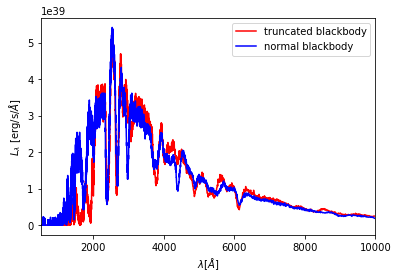

In [6]:
%matplotlib inline
plt.plot(mdl.runner.spectrum_virtual.wavelength,
         mdl.runner.spectrum_virtual.luminosity_density_lambda,
         color='red', label='truncated blackbody')
plt.plot(mdl_norm.runner.spectrum_virtual.wavelength,
         mdl_norm.runner.spectrum_virtual.luminosity_density_lambda,
         color='blue', label='normal blackbody')
plt.xlabel('$\lambda [\AA]$')
plt.ylabel('$L_\lambda$ [erg/s/$\AA$]')
plt.xlim(500, 10000)
plt.legend()